# Pipeline example: mortality, fertility and immigration

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import FertilityAgeSpecificRates
from vivarium_public_health.population import Mortality
from vivarium_public_health.population import ImmigrationDeterministic as Immigration

from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset
from vivarium_public_health.population.spenser_population import compute_migration_rates

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [3]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [4]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_mortality_file': inp_file['paths']['path_to_mortality_file'],
        'path_to_fertility_file': inp_file['paths']['path_to_fertility_file'],
        'path_to_emigration_file': inp_file['paths']['path_to_emigration_file'],
        'path_to_immigration_file': inp_file['paths']['path_to_immigration_file'],
        'path_to_total_population_file': inp_file['paths']['path_to_total_population_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [5]:
inp_file = read_config_file("../config/model_specification_pipeline_004.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Mortality rates

In [6]:
components

 Mortality(),
 ImmigrationDeterministic()]

In [7]:
df = pd.read_csv(config.path_to_mortality_file)
# to save time, only look at locatiosn existing on the test dataset.
mortality_rate_df = df[(df['LAD.code']=='E09000002')]

asfr_data = transform_rate_table(mortality_rate_df,
                                      2011,
                                      2012,
                                      config.population.age_start,
                                      config.population.age_end)

simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)

In [8]:
mortality_rate_df

,Unnamed: 0,LAD.name,LAD.code,ETH.group,MB.0,M0.1,M1.2,M2.3,M3.4,M4.5,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
1,2,Barking and Dagenham,E09000002,WBI,0.003326,0.001683,0.000409,0.000261,0.000211,0.000194,...,0.164990,0.183852,0.204869,0.228290,0.254387,0.283468,0.315874,0.351984,0.392222,0.437060
390,391,Barking and Dagenham,E09000002,WHO,0.003453,0.001731,0.000405,0.000257,0.000197,0.000190,...,0.157919,0.176068,0.196304,0.218865,0.244019,0.272064,0.303332,0.338194,0.377062,0.420398
779,780,Barking and Dagenham,E09000002,MIX,0.003569,0.001777,0.000405,0.000264,0.000202,0.000190,...,0.159100,0.177560,0.198162,0.221154,0.246813,0.275450,0.307410,0.343078,0.382884,0.427309
1168,1169,Barking and Dagenham,E09000002,IND,0.003921,0.001948,0.000426,0.000262,0.000205,0.000206,...,0.155810,0.173602,0.193426,0.215513,0.240123,0.267543,0.298094,0.332133,0.370060,0.412317
1557,1558,Barking and Dagenham,E09000002,PAK,0.004396,0.002163,0.000434,0.000272,0.000222,0.000201,...,0.165502,0.183895,0.204332,0.227041,0.252273,0.280309,0.311462,0.346076,0.384537,0.427273
1946,1947,Barking and Dagenham,E09000002,BAN,0.004186,0.002052,0.000398,0.000252,0.000210,0.000191,...,0.160288,0.177625,0.196837,0.218128,0.241721,0.267865,0.296838,0.328944,0.364524,0.403951
2335,2336,Barking and Dagenham,E09000002,CHI,0.003653,0.001797,0.000382,0.000250,0.000194,0.000187,...,0.162206,0.180609,0.201101,0.223917,0.249321,0.277608,0.309105,0.344175,0.383224,0.426703
2724,2725,Barking and Dagenham,E09000002,OAS,0.003763,0.001870,0.000417,0.000265,0.000200,0.000197,...,0.154870,0.172929,0.193093,0.215609,0.240750,0.268823,0.300169,0.335170,0.374253,0.417892
3113,3114,Barking and Dagenham,E09000002,BLA,0.003718,0.001827,0.000393,0.000266,0.000199,0.000186,...,0.155124,0.172668,0.192197,0.213935,0.238131,0.265063,0.295042,0.328411,0.365555,0.406899
3502,3503,Barking and Dagenham,E09000002,BLC,0.003917,0.001913,0.000384,0.000254,0.000192,0.000173,...,0.156983,0.174834,0.194714,0.216855,0.241513,0.268976,0.299561,0.333624,0.371560,0.413811


## Fertility rates


In [9]:
df = pd.read_csv(config.path_to_fertility_file)
# to save time, only look at locatiosn existing on the test dataset.
fertility_rate_df = df[(df['LAD.code']=='E09000002')]

asfr_data_fertility = transform_rate_table(fertility_rate_df,
                                      2011,
                                      2012,
                                      10,  # starting age for fertility
                                      50,  # finishing age for fertility
                                      [2]) # gender (only females [2])


simulation._data.write("covariate.age_specific_fertility_rate.estimate", asfr_data_fertility)


In [10]:
asfr_data_fertility.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,11,10,BAN,E09000002,0.001371,2,2012,2011
1,12,11,BAN,E09000002,0.005288,2,2012,2011
2,13,12,BAN,E09000002,0.018091,2,2012,2011
3,14,13,BAN,E09000002,0.031652,2,2012,2011
4,15,14,BAN,E09000002,0.050201,2,2012,2011


In [11]:
fertility_rate_df

,LAD.name,LAD.code,ETH.group,F10.11,F11.12,F12.13,F13.14,F14.15,F15.16,F16.17,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
1,Barking and Dagenham,E09000002,WBI,0.000026,0.000234,0.001569,0.003613,0.007285,0.013133,0.021530,...,0,0,0,0,0,0,0,0,0,0
390,Barking and Dagenham,E09000002,WHO,0.000029,0.000263,0.001764,0.004062,0.008189,0.014764,0.024203,...,0,0,0,0,0,0,0,0,0,0
779,Barking and Dagenham,E09000002,MIX,0.000001,0.000023,0.000294,0.000872,0.002184,0.004742,0.009128,...,0,0,0,0,0,0,0,0,0,0
1168,Barking and Dagenham,E09000002,IND,0.000012,0.000153,0.001286,0.003223,0.006976,0.013354,0.023028,...,0,0,0,0,0,0,0,0,0,0
1557,Barking and Dagenham,E09000002,PAK,0.001265,0.004877,0.016688,0.029197,0.046309,0.067626,0.092084,...,0,0,0,0,0,0,0,0,0,0
1946,Barking and Dagenham,E09000002,BAN,0.001371,0.005288,0.018091,0.031652,0.050201,0.073311,0.099824,...,0,0,0,0,0,0,0,0,0,0
2335,Barking and Dagenham,E09000002,CHI,0.000001,0.000019,0.000248,0.000736,0.001842,0.004000,0.007699,...,0,0,0,0,0,0,0,0,0,0
2724,Barking and Dagenham,E09000002,OAS,0.000002,0.000032,0.000411,0.001221,0.003057,0.006638,0.012778,...,0,0,0,0,0,0,0,0,0,0
3113,Barking and Dagenham,E09000002,BLA,0.000542,0.002440,0.009466,0.017465,0.029032,0.044204,0.062474,...,0,0,0,0,0,0,0,0,0,0
3502,Barking and Dagenham,E09000002,BLC,0.000359,0.001617,0.006271,0.011569,0.019230,0.029279,0.041381,...,0,0,0,0,0,0,0,0,0,0


In [12]:
simulation.name

'simulation_context'

In [13]:
# setup emigration rates
df_emigration = pd.read_csv(config.path_to_emigration_file)
df_total_population = pd.read_csv(config.path_to_total_population_file)

df_emigration = df_emigration[
    (df_emigration['LAD.code'] == 'E09000002')]
df_total_population = df_total_population[
    (df_total_population['LAD'] == 'E09000002')]

asfr_data_emigration = compute_migration_rates(df_emigration, df_total_population, 
                                               2011, 
                                               2012, 
                                               config.population.age_start, 
                                               config.population.age_end)

Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than o

Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than o

In [14]:
asfr_data_emigration.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,1,0,BAN,E09000002,0.000000,1,2012,2011
1,2,1,BAN,E09000002,0.002178,1,2012,2011
2,3,2,BAN,E09000002,0.000000,1,2012,2011
3,4,3,BAN,E09000002,0.000000,1,2012,2011
4,5,4,BAN,E09000002,0.000000,1,2012,2011


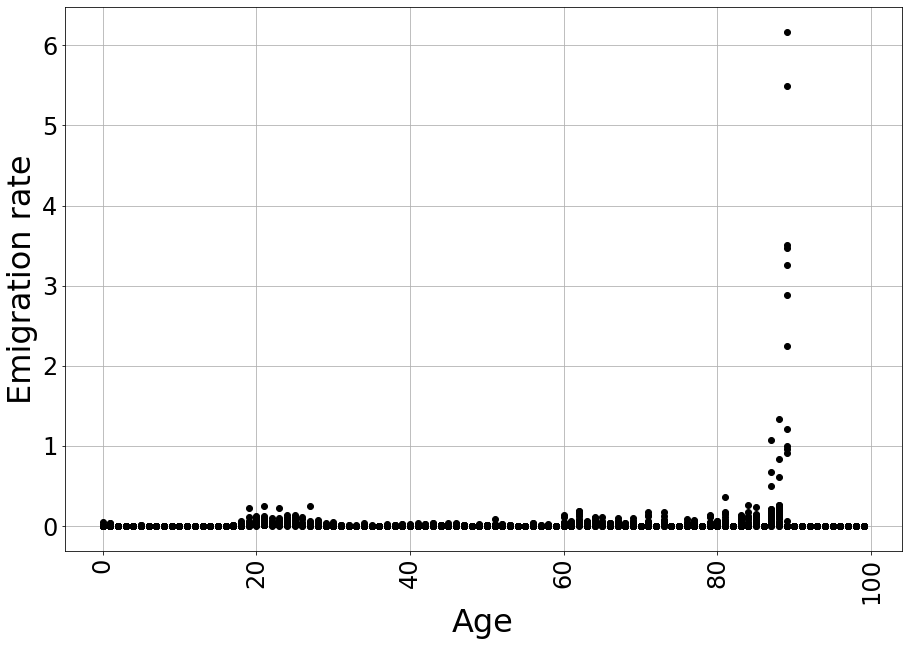

In [15]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_emigration["age_start"], 
         asfr_data_emigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Emigration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [16]:
# setup immigration rates
df_immigration = pd.read_csv(config.path_to_immigration_file)

df_immigration = df_immigration[
    (df_immigration['LAD.code'] == 'E09000002')]

asfr_data_immigration = compute_migration_rates(df_immigration, df_total_population, 
                                                2011, 
                                                2012, 
                                                config.population.age_start, 
                                                config.population.age_end,
                                                normalize=False
                                               )

Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than o

In [17]:
# TESTING
# asfr_data_immigration.loc[asfr_data_immigration["age_start"] > 80, "mean_value"] = 100
asfr_data_immigration["mean_value"].describe()

count    2400.000000
mean        1.081231
std         3.195961
min         0.000000
25%         0.000000
50%         0.105836
75%         0.667866
max        34.451292
Name: mean_value, dtype: float64

In [18]:
# XXX CHECK!!!
total_immigrants = df_immigration[df_immigration.columns[4:]].sum().sum()
print(total_immigrants)

2612.8158731376566


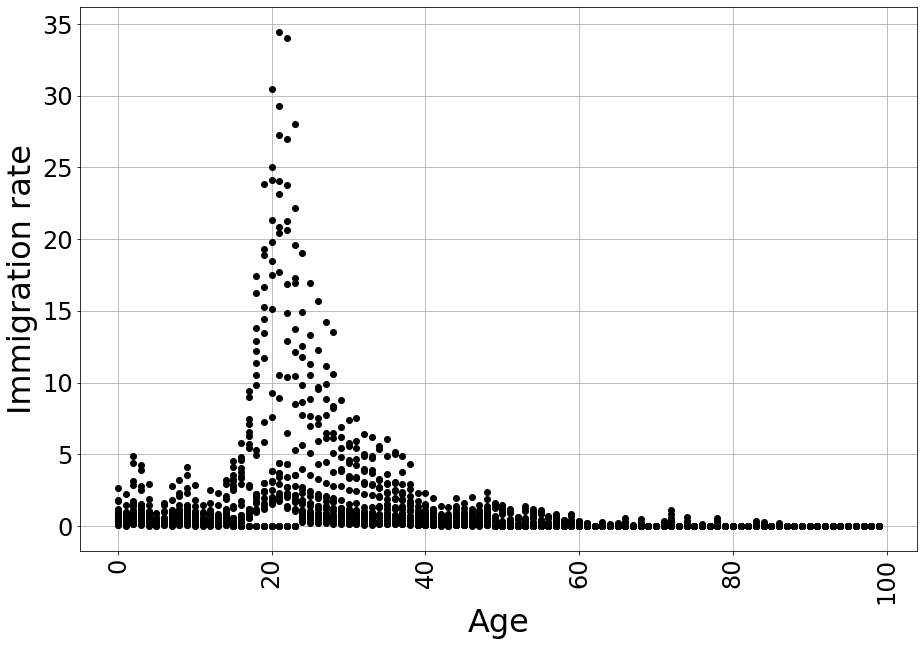

In [19]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_immigration["age_start"], 
         asfr_data_immigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Immigration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [20]:
simulation._data.write("cause.all_causes.cause_specific_immigration_rate", asfr_data_immigration)
simulation._data.write("cause.all_causes.cause_specific_total_immigrants_per_year", total_immigrants)

## Setup a simulation and run for `num_days`

In [21]:
sim_start = time.time()

simulation.setup()
num_days = 365*1 + 10
simulation.run_for(duration=pd.Timedelta(days=num_days))



sim_end = time.time()

2020-07-21 16:19:00.980 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-07-21 16:19:04.427 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-21 16:19:04.427 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-07-21 16:19:51.799 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-07-21 16:20:05.655 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-21 16:20:34.769 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-21 16:20:48.257 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-07-21 16:21:01.801 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-10 00:00:00
2020-07-21 16:21:15.226 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-20 00:00:00
2020-07-21 16:21:36.335 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-02 00:00:00
2020-07-21 16:21:49.842 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-12 00:00:00
2020-07-21 16:21:59.615 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-22 00:00:00
2020-07-21 16:22:13.004 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-07-21 16:22:26.665 | DEBUG    | vivarium.framework.engi

In [22]:
pop = simulation.get_population()

print(f"Total time: {sim_end - sim_start}")
print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
print (f'#dead: {len(pop[pop["alive"]!="alive"])}')
try:
    print (f'#new borns: {len(pop[pop["parent_id"]!=-1])}')
except Exception:
    print("Fertility component should be activated to print new borns!")

Total time: 672.0677759647369
#alive: 520710
#dead: 4429
Fertility component should be activated to print new borns!


In [23]:
pop["cause_of_death"].value_counts()

not_dead      520710
all_causes      4429
Name: cause_of_death, dtype: int64

In [24]:
pop[pop["cause_of_death"] == "all_causes"].head()

,tracked,cause_of_death,years_of_life_lost,sex,entrance_time,exit_time,age,ethnicity,alive,location
1231,True,all_causes,34.050411,1.0,2010-12-22,2011-02-20,47.109589,WBI,dead,E09000002
1295,True,all_causes,32.420274,1.0,2010-12-22,2011-10-08,48.739726,WBI,dead,E09000002
1522,True,all_causes,28.077808,1.0,2010-12-22,2011-02-10,53.082192,WBI,dead,E09000002
1723,True,all_causes,22.858630,1.0,2010-12-22,2011-05-01,58.301370,WBI,dead,E09000002
1819,True,all_causes,20.023014,1.0,2010-12-22,2011-03-02,61.136986,WBI,dead,E09000002


## Plot results

In [25]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2012-01-01", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2012-01-01 00:00:00


In [26]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    curr_pop = pop[pop["entrance_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    current_alive_population = len(curr_pop) - len(pop_dead)
    population_axis.append(current_alive_population)
    
    curr_pop_eth = len(curr_pop[curr_pop["ethnicity"].isin(sel_ethnicity)])
    current_alive_population_eth = curr_pop_eth - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(current_alive_population_eth)
    
    curr_pop_male = len(curr_pop[curr_pop["sex"] == 1])
    current_alive_population_male = curr_pop_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(current_alive_population_male)
    
    curr_pop_female = len(curr_pop[curr_pop["sex"] == 1])
    current_alive_population_female = curr_pop_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(current_alive_population_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [27]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

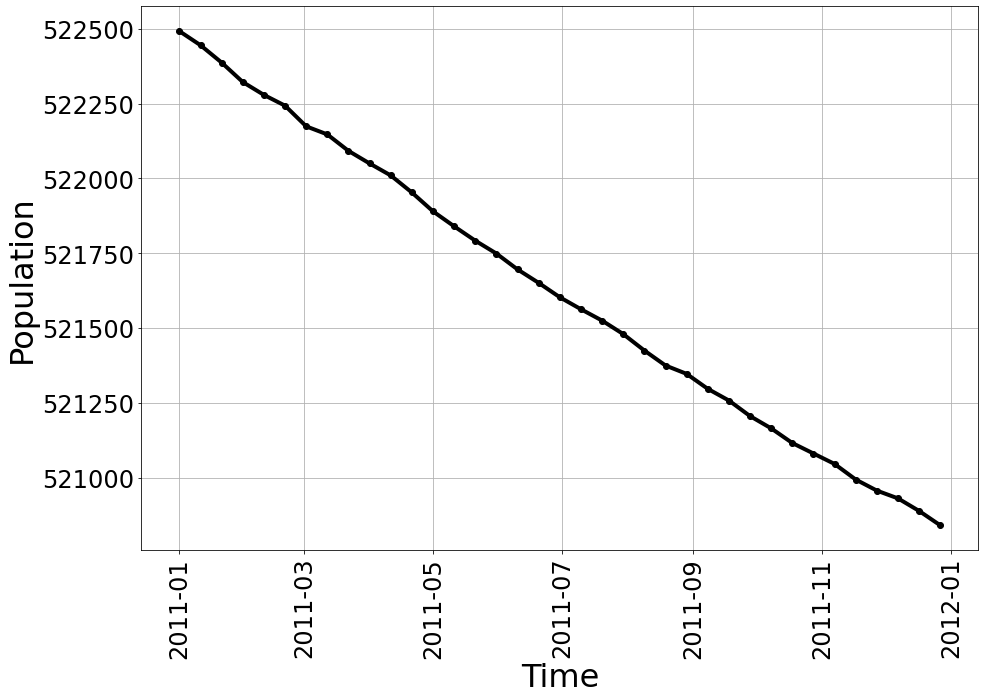

In [28]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

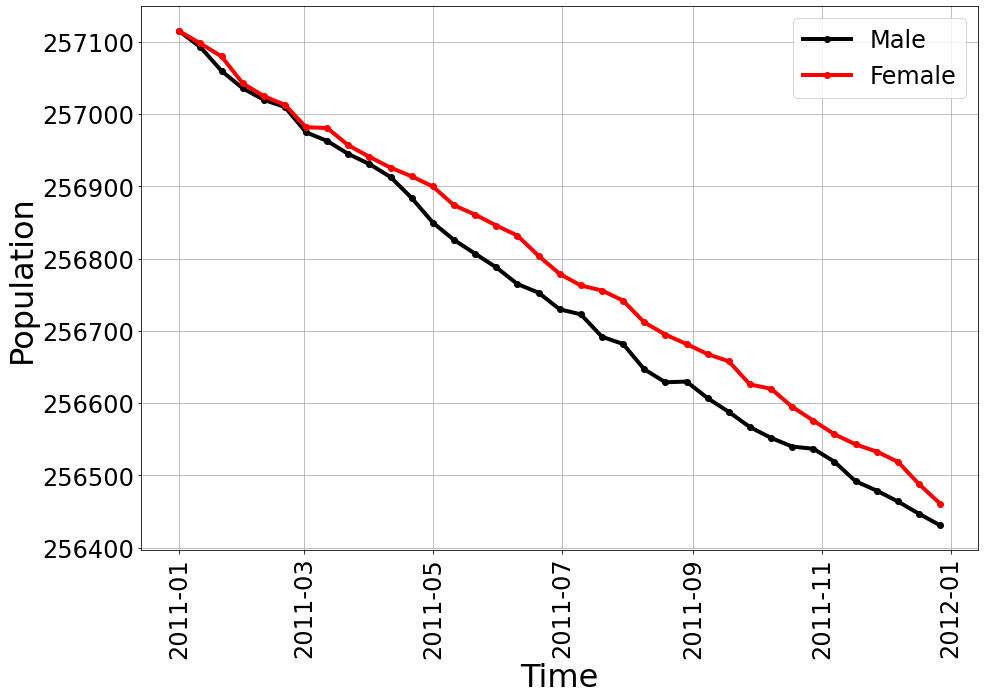

In [29]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

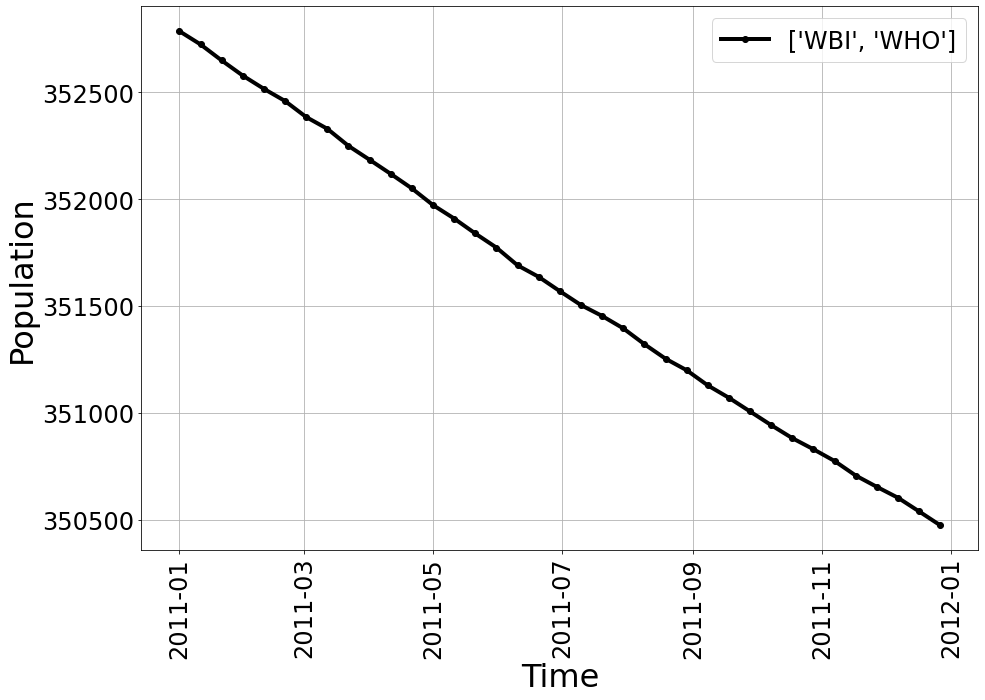

In [30]:
# Population (ethnicity)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_ETH_axis, 
         c='k', lw=4, marker="o", 
         label=sel_ethnicity
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [31]:
# only immigrants
pop_immig = pop[pop["entrance_time"] > curr_time.strftime("2011-01-01")]

In [32]:
pop["ethnicity"].value_counts()

WBI    337240
PAK    107149
WHO     16397
IND     13987
MIX     13059
BAN     10004
OAS      8151
OTH      7824
BLA      5517
BLC      3614
CHI      2111
OBL        14
Name: ethnicity, dtype: int64

In [33]:
pop_immig['ethnicity'].value_counts()

WHO    648
BLA    506
IND    398
PAK    391
WBI    202
BAN    127
OAS    105
OTH     74
MIX     62
BLC     27
CHI     21
OBL     14
Name: ethnicity, dtype: int64

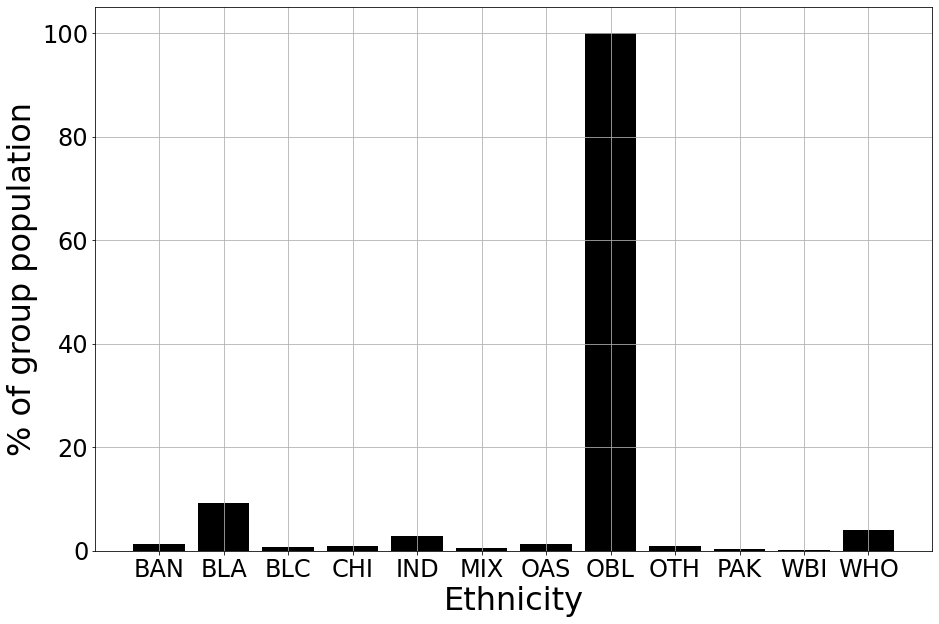

In [34]:
series2plot = pop_immig['ethnicity'].value_counts() / pop["ethnicity"].value_counts() * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of group population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

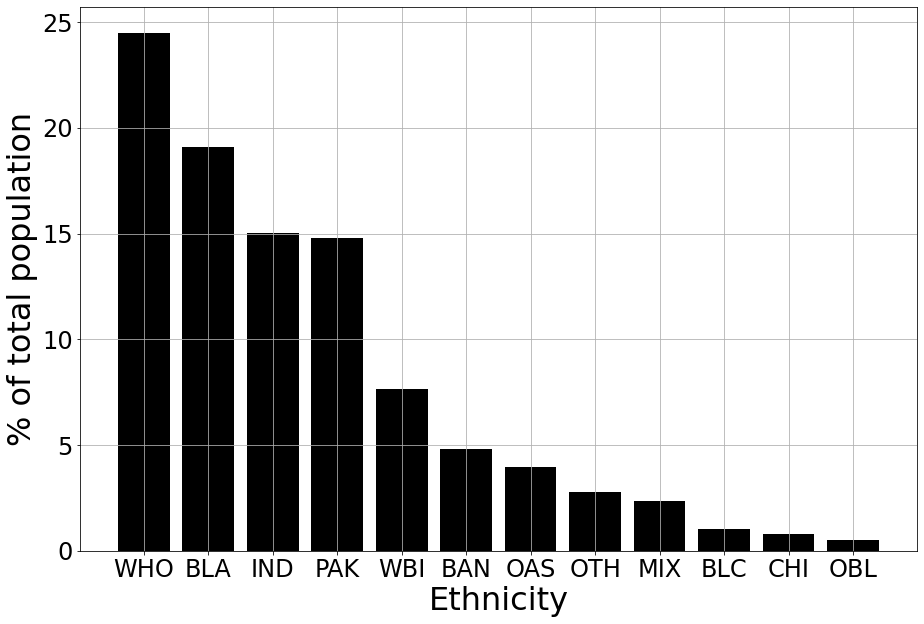

In [35]:
series2plot = pop_immig['ethnicity'].value_counts() / len(pop_immig["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of total population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

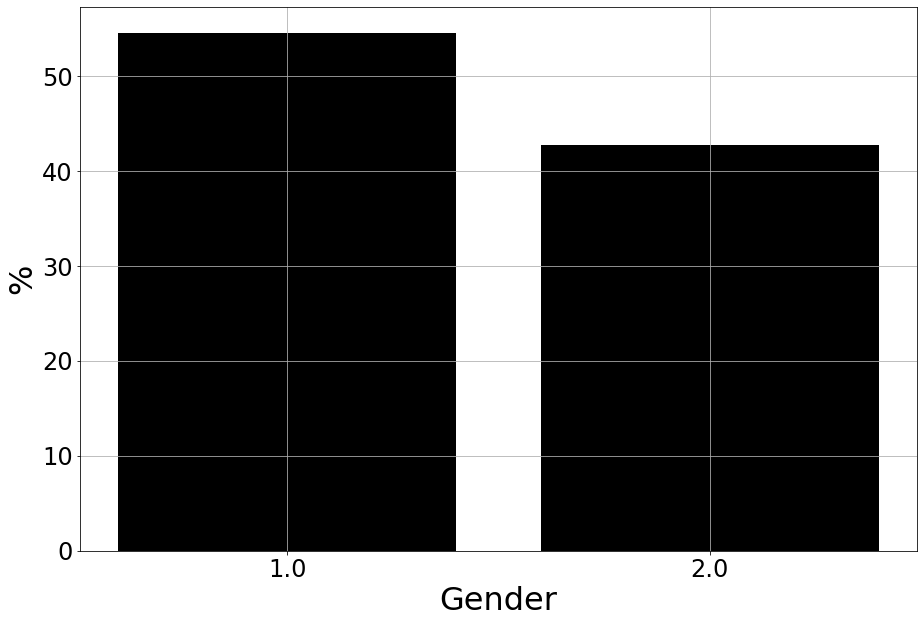

In [36]:
series2plot = pop_immig['sex'].value_counts() / len(pop_immig["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

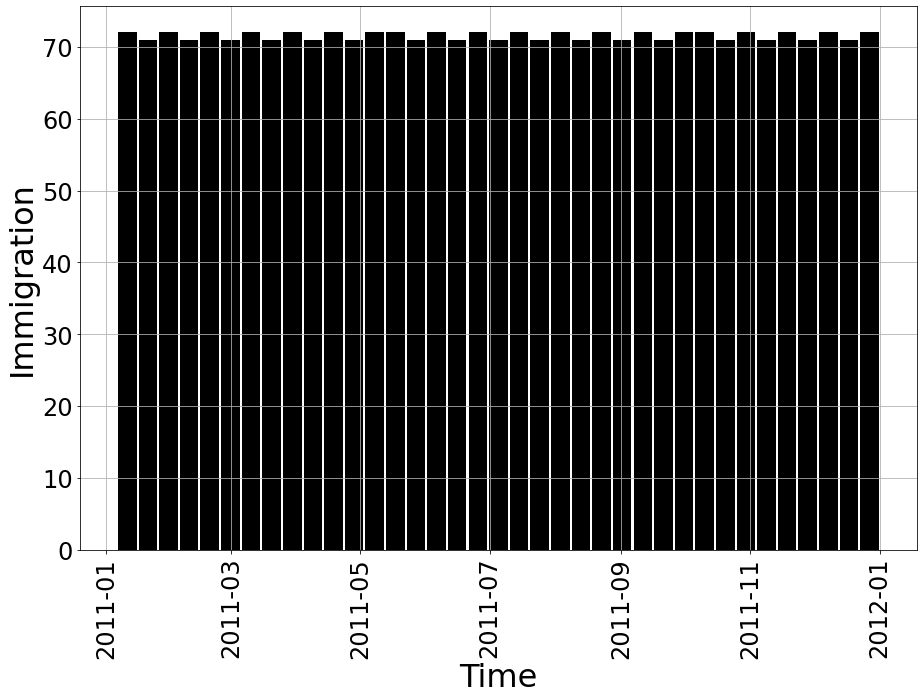

In [39]:
plt.figure(figsize=(15, 10))

pop_immig["entrance_time"].hist(bins=int((365+10)/10), 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Immigration", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()